The [Travelling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP) is a classic example of an NP-hard studied by computer scientists everywhere. Not only is it an interesting problem from a mathematical perspective, the TSP also represents a key problem faced in industry. It is known as combinatorial optimization problem, and techniques for solving it can be applied to many different problem domains including routing and layout optimization. In this post I will explore using different heuristics to compute a reasonable solution using Python. 

The first step in any case study such as this is defining your problem. I've decided to take a look at finding the shortest route between all 44 of Canada's [National Parks](http://www.pc.gc.ca/progs/np-pn/recherche-search_e.asp?p=1). Sounds like a fun idea for a (lengthy!) road trip. With that decided, it's time to get some data.

In [1]:
import pandas as pd
import re
import requests
from IPython.display import display
from lxml import html


# Please scrape responsibly!
response = requests.get('https://en.wikipedia.org/'
                        'wiki/List_of_National_Parks_of_Canada')
wiki = html.fromstring(response.text)
tables = wiki.xpath('.//table[contains(@class, "wikitable")]')
parks = tables[0].xpath('./tr')[1:]

park_df = pd.DataFrame([], 
                       columns=['Park', 'Latitude', 'Longitude'], 
                       dtype='float64')
for park in parks:
    try:
        link = park.xpath('.//td/a')[0]
        response = requests.get('https://en.wikipedia.org' + 
                                link.attrib['href'])
        park_wiki = html.fromstring(response.text)
        park_lat = park_wiki.xpath(
            './/span[@class="latitude"]')[0].text
        park_lon = park_wiki.xpath(
            './/span[@class="longitude"]')[0].text
        park_name = link.attrib['title']
        # Assume all coordinates are N and W
        # Convert minutes and seconds to degrees
        latitude = [int(x) for x in re.findall('[0-9]+', park_lat)]
        longitude = [-1 * int(y) for y in re.findall('[0-9]+', 
                                                     park_lon)]
        # UPDATE: 2015-07-09
        # A week after I posted this Qausuittuq National Park 
        # was created on 2015-06-24!
        # Updated error handling code
        
        if len(latitude) != 3:
            latitude.append(0)
            
        if len(longitude) != 3:
            longitude.append(0)
        
        park_lat = (latitude[0] + 
                    (latitude[1]/60) + 
                    (latitude[2]/3600))
        park_lon = (longitude[0] + 
                    (longitude[1]/60) + 
                    (longitude[2]/3600))

    except IndexError:
        # Certain wiki pages don't have the latitude and logitude 
        # We'll use http://wiki.openstreetmap.org/wiki/Nominatim 
        # to do a reverse lookup
        park_name = link.attrib['title']
        response = requests.get(
            'http://nominatim.openstreetmap.org/'
            'search/{0}?format=json'.format(park_name)).json()
        try:
            park_lat = response[0]['lat']
            park_lon = response[0]['lon']
        except IndexError:
            # Mingan Archipelago National Park Reserve
            # could not be found but a Google search 
            # provided coordinates of 50.2167° N,63.1667° W
            if park_name == ('Mingan Archipelago '
                             'National Park Reserve'):
                park_lat = 50.2167
                park_lon = -63.1667
            else:
                raise InputError(
                    '{0} not found.'.format(
                        link.attrib['title']))
            
    df = pd.DataFrame(
        [[park_name, park_lat, park_lon]], 
        columns=['Park', 'Latitude', 'Longitude'], 
        dtype='float64')
    park_df = park_df.append(df)
        
park_df.reset_index(drop=True, inplace=True)
display(park_df)

,Park,Latitude,Longitude
0,Aulavik National Park,73.700278,-119.919444
1,Auyuittuq National Park,67.883333,-65.016667
2,Banff National Park,51.500000,-116.000000
3,Bruce Peninsula National Park,45.238889,-81.614167
4,Cape Breton Highlands National Park,46.716667,-60.659722
5,Elk Island National Park,53.614444,-112.866111
6,Forillon National Park,48.900000,-64.350000
7,Fundy National Park,45.595278,-64.953889
8,Georgian Bay Islands National Park,44.877778,-79.874722
9,Glacier National Park (Canada),51.300000,-117.518611


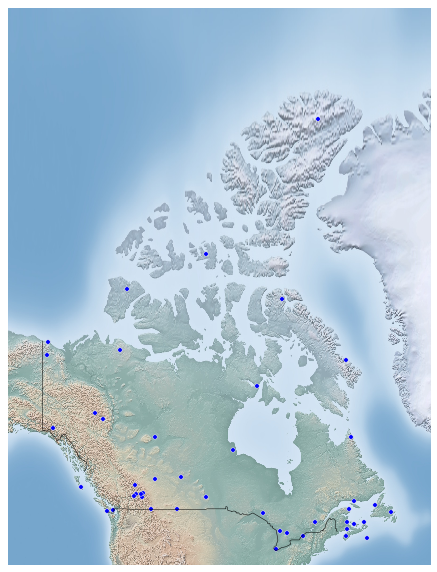

In [10]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

matplotlib.style.use('ggplot')

plt.figure(figsize=(10,10))
canada = Basemap(projection='merc', 
                 resolution = 'l', 
                 urcrnrlon=park_df['Longitude'].max() + 10, 
                 urcrnrlat=park_df['Latitude'].max() + 3, 
                 llcrnrlon=park_df['Longitude'].min() - 10, 
                 llcrnrlat=park_df['Latitude'].min() - 3)
canada.shadedrelief()
canada.drawcountries()
canada.scatter(park_df['Longitude'].values, 
               park_df['Latitude'].values, 
               latlon=True);

Before I get started generating a solution I first need to compute the distance between each of the parks.

In [4]:
import numpy as np

EARTH_RADIUS = 6371

def haversine(start_lon, start_lat, end_lon, end_lat):
    """Computer the haversine distance between points."""
    start_lon = np.radians(start_lon)
    start_lat = np.radians(start_lat)
    end_lon = np.radians(end_lon)
    end_lat = np.radians(end_lat)

    dlon = end_lon - start_lon
    dlat = end_lat - start_lat

    a = (np.sin(dlat/2)**2 + np.cos(start_lat) * 
         np.cos(end_lat) * np.sin(dlon/2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return np.nan_to_num(c * EARTH_RADIUS)

def compute_distances(row):
    """Expand each row to get the distance between parks."""
    park_df[row['Park']] = haversine(row['Longitude'], 
                                     row['Latitude'], 
                                     park_df['Longitude'], 
                                     park_df['Latitude'])
    
park_df.apply(compute_distances, axis=1)
display(park_df.drop(['Latitude', 'Longitude'], axis=1).head())

,Park,Aulavik National Park,Auyuittuq National Park,Banff National Park,Bruce Peninsula National Park,Cape Breton Highlands National Park,Elk Island National Park,Forillon National Park,Fundy National Park,Georgian Bay Islands National Park,...,Terra Nova National Park,Thousand Islands National Park,Torngat Mountains National Park,Tuktut Nogait National Park,Ukkusiksalik National Park,Vuntut National Park,Wapusk National Park,Waterton Lakes National Park,Wood Buffalo National Park,Yoho National Park
0,Aulavik National Park,0.000000,2024.432964,2475.439346,3693.666910,4130.762458,2256.700776,3797.055546,4116.291588,3775.489235,...,4154.505377,3933.053852,2782.379602,546.673899,1540.350964,925.238910,2106.518889,2756.821509,1618.703581,2485.471880
1,Auyuittuq National Park,2024.432964,0.000000,3251.463308,2694.862650,2366.752790,2935.882836,2111.178459,2478.321359,2699.816402,...,2239.699262,2693.497110,941.000543,2246.868140,1017.247061,2910.133622,1799.231647,3388.150699,2472.140891,3280.974892
2,Banff National Park,2475.439346,3251.463308,0.000000,2607.071573,3965.777760,316.426811,3610.714369,3735.720794,2746.434066,...,4312.776317,3046.055381,3308.496387,1949.809836,2235.552520,2266.494418,1604.468300,310.484588,896.763324,35.679578
3,Bruce Peninsula National Park,3693.666910,2694.862650,2607.071573,0.000000,1622.683294,2419.997878,1365.939889,1298.635950,142.402290,...,2123.582367,457.166707,1973.392664,3454.125271,2262.017965,4134.737974,1608.812456,2460.080136,2609.824122,2640.477158
4,Cape Breton Highlands National Park,4130.762458,2366.752790,3965.777760,1622.683294,0.000000,3708.784394,367.195482,353.420756,1499.777010,...,543.092450,1217.919895,1429.984001,4115.094443,2610.035714,4848.763013,2509.010515,3897.591966,3654.981090,4001.364509


Let's start by seeing how efficient a nearest neighbour algorithm, also known as a greedy search, is at solving the TSP. A nearest neighbour algorithm is a simple heuristic outlined in the the following pseudocode:
    
    1. Pick a random starting point
    2. While there are unvisited points:
        a. Find the nearest univisited point 
        b. Set the nearest univisited point as the next leg of the tour
        c. Update the list of univisited points
        
Here is my implementation.

In [5]:
import random
import sys

# A production algorithm should use a random start
# init_park = random.randint(0, len(park_df) - 1)
init_park = 7
nn_tour = [init_park]
while len(nn_tour) < len(park_df):
    current_park = park_df.loc[
        nn_tour[-1]].replace(0, sys.maxsize)
    next_park_name = current_park.drop(
        ['Park', 'Latitude', 'Longitude']).drop(
        park_df['Park'].loc[nn_tour]).idxmin()
    nn_tour.append(
        park_df[park_df['Park'] == next_park_name].index[0])
    
print(nn_tour)

[7, 16, 19, 28, 4, 33, 6, 21, 11, 35, 37, 1, 34, 30, 0, 38, 14, 40, 23, 24, 17, 13, 25, 12, 22, 9, 44, 2, 18, 15, 5, 27, 32, 10, 42, 43, 41, 39, 29, 3, 8, 36, 20, 26, 31]


In [6]:
init_start = park_df.iloc[nn_tour[0]]
init_end = park_df.iloc[nn_tour[1]]
fin_start = park_df.iloc[nn_tour[-2]]
fin_end = park_df.iloc[nn_tour[-1]]

print('Initial leg: {0:.2f} km'.format(
        haversine(init_start['Longitude'], 
                  init_start['Latitude'], 
                  init_end['Longitude'], 
                  init_end['Latitude'])))
print('Final leg: {0:.2f} km'.format(
        haversine(fin_start['Longitude'],
                  fin_start['Latitude'], 
                  fin_end['Longitude'], 
                  fin_end['Latitude'])))

Initial leg: 134.62 km
Final leg: 4491.85 km


If the initial and final tour lengths are comparable in magnitude then this is a good indication that the computed solution is a reasonable one: [Wikipedia](https://en.wikipedia.org/?title=Nearest_neighbour_algorithm).

With a 30x increase from the first to last leg of the journey, it looks like we can definitely improve on this result. Let's see how this journey looks on a map.

Total trip length: 26882.85 km


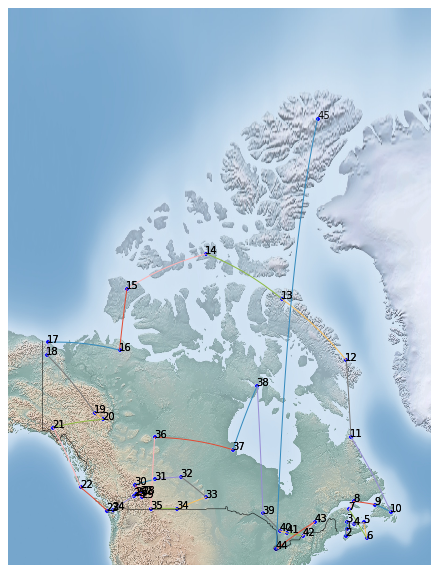

In [11]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def calc_tour_len(tour):
    tour_length = []
   
    for pair in pairwise(tour):
        init = park_df.iloc[pair[0]]
        fin  = park_df.iloc[pair[1]]
        init_coordinates = canada(
            init['Longitude'], 
            init['Latitude'])
        fin_coordinates = canada(
            fin['Longitude'], 
            fin['Latitude'])
        tour_length.append(
            haversine(init['Longitude'], 
                      init['Latitude'], 
                      fin['Longitude'], 
                      fin['Latitude']))
        
    return tour_length

def plot_tour(canada, tour):
    plt.figure(figsize=(10,10))
    canada.shadedrelief()
    canada.drawcountries()
    canada.scatter(
        park_df['Longitude'].values, 
        park_df['Latitude'].values, 
        latlon=True)

    tour_index = 0 
    for pair in pairwise(tour):
        tour_index += 1
        init = park_df.iloc[pair[0]]
        fin  = park_df.iloc[pair[1]]
        init_coordinates = canada(
            init['Longitude'], 
            init['Latitude'])
        fin_coordinates = canada(
            fin['Longitude'], 
            fin['Latitude'])
        # The numbers represent the order in which 
        # the parks are visited
        plt.text(init_coordinates[0], 
                 init_coordinates[1], 
                 tour_index)
        plt.text(fin_coordinates[0], 
                 fin_coordinates[1], 
                 tour_index + 1)
        # Any invisible legs of the tour are due to
        # the great circle distance going outside 
        # the boundaries of the map
        canada.drawgreatcircle(init['Longitude'], 
                               init['Latitude'], 
                               fin['Longitude'], 
                               fin['Latitude'])
        
    return canada


nn_length = calc_tour_len(nn_tour)
plot_tour(canada, nn_tour)
    
print('Total trip length: {0:.2f} km'.format(
        sum(nn_length)))

Tour leg standard deviation: 711.02 km


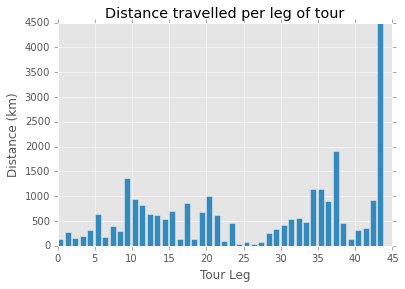

In [12]:
plt.bar(list(range(len(nn_tour) - 1)), nn_length)
plt.title('Distance travelled per leg of tour')
plt.xlabel('Tour Leg')
plt.ylabel('Distance (km)')

print('Tour leg standard deviation: {0:.2f} km'.format(
        np.std(nn_length)))

So there are some large spikes that we definitely want to try and optimize in this journey so a good goal would be to lower the standard deviation observed within a tour from 711.02 km. 

We could use a K-Nearest Neighbours algorithm, in which we expand the search to the nearest K neighbours at each leg; however, I would like to try using a different approach to solving the TSP.

An efficient algorithm that is often used is the 2-opt approach. This is a heuristic in which 2 edges of the tour are dropped and a shorter tour is formed given these new breaks. If an improvement is made then you must restart the optimization of the tour from the beginning. Using [this pseudocode](https://en.wikipedia.org/wiki/2-opt) as a template I implemented the algorithm.

Let's see how much that improves the tour.

In [9]:
def two_opt(tour, tour_length):
    """Calculates a single two opt pass on a given tour.
    
    Returns the optimized tour, 
    the tour's length and 
    a boolean flag to indicate if tour is only partially optimized."""
    for first_index in range(1, len(tour) - 1):
        for second_index in range(first_index + 1, len(tour)):
            new_tour = (tour[:first_index] + 
                        tour[first_index:second_index][::-1] + 
                        tour[second_index:])
            new_length = calc_tour_len(new_tour)
            if sum(new_length) < sum(tour_length):
                tour_length = new_length
                tour = new_tour
                return tour, tour_length, True
    
    return tour, tour_length, False
    
two_opt_length = nn_length
two_opt_tour = nn_tour
repeat = True
while repeat:
    (two_opt_tour, 
     two_opt_length, 
     repeat) = two_opt(two_opt_tour, two_opt_length)

print(two_opt_tour)

[7, 16, 28, 4, 33, 35, 11, 21, 6, 19, 20, 36, 8, 26, 3, 29, 41, 39, 43, 27, 32, 10, 42, 18, 2, 5, 15, 44, 9, 22, 12, 25, 13, 17, 24, 23, 40, 14, 38, 0, 30, 34, 37, 1, 31]


Total trip length: 23108.13 km


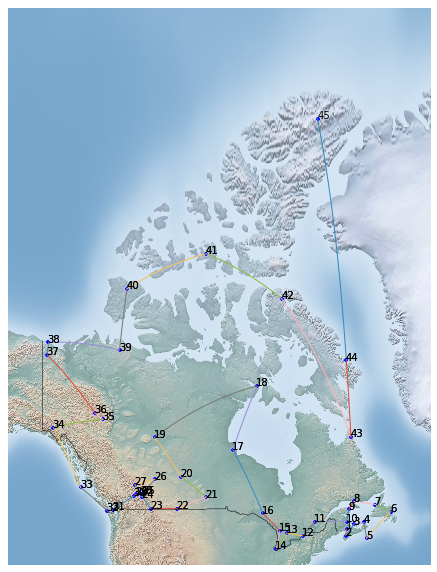

In [13]:
plot_tour(canada, two_opt_tour)
print('Total trip length: {0:.2f} km'.format(
        sum(two_opt_length)))

Tour leg standard deviation: 392.95 km
Change in tour distance: 3774.72 km


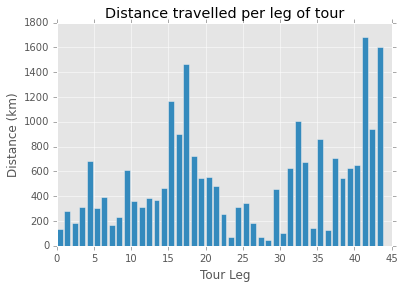

In [14]:
plt.bar(list(range(len(two_opt_tour) - 1)), two_opt_length)
plt.title('Distance travelled per leg of tour')
plt.xlabel('Tour Leg')
plt.ylabel('Distance (km)')

print('Tour leg standard deviation: {0:.2f} km'.format(
        np.std(two_opt_length)))
print('Change in tour distance: {0:.2f} km'.format(
        sum(nn_length) - sum(two_opt_length)))

So the 2-optimized tour reduced the total journey length by 3774.72 km total and the standard deviation of tour legs to 392.95 km.

The 3-opt algorithm is a further optimization which looks swapping three edges during a single iteration. This approach has been generalized in the Lin–Kernighan heuristic which can solve up to k-opt by determining the optimal value of k edges to swap at each iteration. I think I'll leave the exploration of these advanced algorithms for another post.

If I want to take things further I cculd also try and find an exact solution. [Concorde](http://www.math.uwaterloo.ca/tsp/concorde.html) is one of the best tools you can use for solving the TSP in this manner. It is very fast and has implementations for many different algorithms and approaches.